In [141]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from FeatureEngineering_2 import *

from joblib import dump, load
from AdvancedModel_helpers import *
from sklearn.calibration import calibration_curve

In [19]:
from comet_ml import API

api = API(api_key="v5q8O8LftZtvOcoXlVM8Ku8fH")

experiment = api.get_model(workspace='hfereidouni',model_name='random_forest_kbest_mi_random_forest_no_tuning')

In [3]:
if not os.path.exists("csv/test"):
    os.makedirs("csv/test")
for year in [2020]: # 2020 has been excluded to be reserved as the test set
    read_a_season("../nhl_data/",year).to_csv('csv/test/tidy_{season}.csv'.format(season = year), sep = ',', index = False)

  0%|          | 0/6433 [00:00<?, ?it/s]

100%|██████████| 6433/6433 [00:33<00:00, 194.25it/s]  


In [183]:
directory = 'csv/test'

# Get a list of csv file names within the directory
csv_files = [f for f in os.listdir(directory) if f.endswith('.csv')]

# Sort the list of csv files
csv_files.sort()

# List to hold your DataFrames
dataframes_list = []

# Loop over the sorted list of csv files with tqdm for progress indication
for filename in tqdm(csv_files, desc="Loading files", unit="file"):
    file_path = os.path.join(directory, filename)
    df = pd.read_csv(file_path)

    # Filter the DataFrame to only include rows where 5th and 6th digits of 'game_id' are '02' (Regular Season)
    df = df[df['game_id'].astype(str).str[4:6] == '02']

    dataframes_list.append(df)

# Concatenate all the DataFrames in the list into a single DataFrame
df_regular = pd.concat(dataframes_list, ignore_index=True)

# Sort the DataFrame first by 'game_id' and then by 'event_idx'
df_regular = df_regular.sort_values(by=['game_id', 'event_idx'])

# Reset the index of the sorted DataFrame
df_regular = df_regular.reset_index(drop=True)

Loading files: 100%|██████████| 1/1 [00:00<00:00,  3.57file/s]


In [184]:
directory = 'csv/test'

# Get a list of csv file names within the directory
csv_files = [f for f in os.listdir(directory) if f.endswith('.csv')]

# Sort the list of csv files
csv_files.sort()

# List to hold your DataFrames
dataframes_list = []

# Loop over the sorted list of csv files with tqdm for progress indication
for filename in tqdm(csv_files, desc="Loading files", unit="file"):
    file_path = os.path.join(directory, filename)
    df = pd.read_csv(file_path)

    # Filter the DataFrame to only include rows where 5th and 6th digits of 'game_id' are '02' (Regular Season)
    df = df[df['game_id'].astype(str).str[4:6] == '03']

    dataframes_list.append(df)

# Concatenate all the DataFrames in the list into a single DataFrame
df_off = pd.concat(dataframes_list, ignore_index=True)

# Sort the DataFrame first by 'game_id' and then by 'event_idx'
df_off = df_off.sort_values(by=['game_id', 'event_idx'])

# Reset the index of the sorted DataFrame
df_off = df_off.reset_index(drop=True)

Loading files: 100%|██████████| 1/1 [00:00<00:00,  3.79file/s]


### Regular season

In [185]:
df_regular= df_regular[['game_time','period','x','y','shot_type','last_event_type',
       'x_coord_last_event', 'y_coord_last_event', 'Time_from_the_last_event',
       'Distance_from_the_last_event', 'Rebound', 'change_shot_angle', 'Speed',
       'shot_dist','angle_net', 'is_goal']]

In [186]:
test_shot_type_oh = onehot_generator(df_regular[['shot_type']])
test_last_event_type_oh = onehot_generator(df_regular[['last_event_type']])
test_regular_df= df_regular.drop(columns=['shot_type','last_event_type'])
test_regular_df = pd.concat([test_regular_df,
                       test_shot_type_oh.set_index(test_regular_df.index),
                       test_last_event_type_oh.set_index(test_regular_df.index)],axis=1)

In [187]:
test_regular_df = test_regular_df.drop(columns=['change_shot_angle'])
test_regular_df = test_regular_df.dropna()

In [188]:
test_regular_df_X = test_regular_df.drop(columns=['is_goal'])
test_regular_df_Y = test_regular_df[['is_goal']]

In [189]:
# Download an Experiment Model:
# Uncomment if needed:
# experiment.download("1.0.0","./models/",expand=True)

In [190]:
log_reg_1 = load('./models/Log_Reg_angle_only.joblib')
log_reg_2 = load('./models/Log_Reg_shot_dist_only.joblib')
log_reg_3 = load('./models/Log_Reg_shot_dist_and_angle.joblib')
xgboost = load('./models/xgboost4.joblib')
rf = load('./models/Random_Forest_KBest_MI_random_forest_no_tuning.joblib')

In [191]:
regular_reg_1_X = test_regular_df[['angle_net']]
regular_reg_2_X = test_regular_df[['shot_dist']]
regular_reg_3_X = test_regular_df[['shot_dist','angle_net']]
regular_reg_4_X = test_regular_df[['game_time', 'period', 'y', 'Time_from_the_last_event', 'shot_dist', 'shot_type_Backhand', 'shot_type_Deflected', 'shot_type_Wrap-around', 'shot_type_Wrist Shot', 'last_event_type_Hit', 'last_event_type_Missed Shot', 'last_event_type_Shot', 'last_event_type_Stoppage']]
regular_reg_5_X = test_regular_df[['x','y','Time_from_the_last_event','Distance_from_the_last_event',
 'Rebound','Speed','shot_dist','angle_net','shot_type_Wrist Shot','last_event_type_Shot']]

In [192]:
val_res_1 = log_reg_1.predict_proba(regular_reg_1_X)
val_res_2 = log_reg_2.predict_proba(regular_reg_2_X)
val_res_3 = log_reg_3.predict_proba(regular_reg_3_X)
val_res_4 = xgboost.predict_proba(regular_reg_4_X)
val_res_5 = rf.predict_proba(regular_reg_5_X)

### ROC AUC Compare

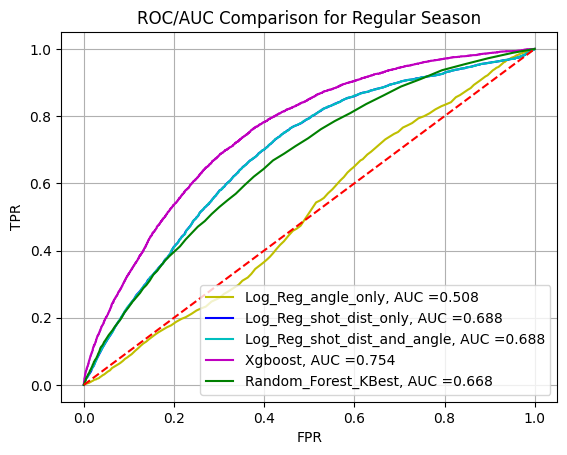

In [193]:
fpr_1,tpr_1,threshold_1 = metrics.roc_curve(test_regular_df_Y,val_res_1[:,1])
fpr_2,tpr_2,threshold_2 = metrics.roc_curve(test_regular_df_Y,val_res_2[:,1])
fpr_3,tpr_3,threshold_3 = metrics.roc_curve(test_regular_df_Y,val_res_3[:,1])
fpr_4,tpr_4,threshold_4 = metrics.roc_curve(test_regular_df_Y,val_res_4[:,1])
fpr_5,tpr_5,threshold_5 = metrics.roc_curve(test_regular_df_Y,val_res_5[:,1])

auc_1 = metrics.auc(fpr_1,tpr_1)
auc_2 = metrics.auc(fpr_2,tpr_2)
auc_3 = metrics.auc(fpr_3,tpr_3)
auc_4 = metrics.auc(fpr_4,tpr_4)
auc_5 = metrics.auc(fpr_5,tpr_5)


plt.title(f'ROC/AUC Comparison for Regular Season')
plt.plot(fpr_1,tpr_1,'y',label=f"Log_Reg_angle_only, AUC =%0.3f"%auc_1)
plt.plot(fpr_2,tpr_2,'b',label=f"Log_Reg_shot_dist_only, AUC =%0.3f"%auc_2)
plt.plot(fpr_3,tpr_3,'c',label=f"Log_Reg_shot_dist_and_angle, AUC =%0.3f"%auc_3)
plt.plot(fpr_4,tpr_4,'m',label=f"Xgboost, AUC =%0.3f"%auc_4)
plt.plot(fpr_5,tpr_5,'g',label=f"Random_Forest_KBest, AUC =%0.3f"%auc_5)

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.grid(True)
plt.legend(loc="lower right")


In [194]:
probas_and_label_1 = helper_df(test_regular_df_Y,val_res_1)
probas_and_label_2 = helper_df(test_regular_df_Y,val_res_2)
probas_and_label_3 = helper_df(test_regular_df_Y,val_res_3)
probas_and_label_4 = helper_df(test_regular_df_Y,val_res_4)
probas_and_label_5 = helper_df(test_regular_df_Y,val_res_5)

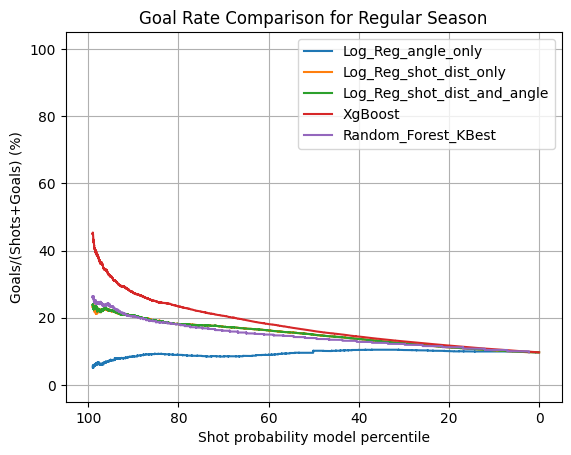

In [195]:
start_length = int(len(probas_and_label_1)*0.01)
plt.plot(probas_and_label_1['rank'].iloc[start_length:],probas_and_label_1['#goal/#goal+#shot'].iloc[start_length:],label="Log_Reg_angle_only")
plt.plot(probas_and_label_2['rank'].iloc[start_length:],probas_and_label_2['#goal/#goal+#shot'].iloc[start_length:],label="Log_Reg_shot_dist_only")
plt.plot(probas_and_label_3['rank'].iloc[start_length:],probas_and_label_3['#goal/#goal+#shot'].iloc[start_length:],label="Log_Reg_shot_dist_and_angle")
plt.plot(probas_and_label_4['rank'].iloc[start_length:],probas_and_label_4['#goal/#goal+#shot'].iloc[start_length:],label="XgBoost")
plt.plot(probas_and_label_5['rank'].iloc[start_length:],probas_and_label_5['#goal/#goal+#shot'].iloc[start_length:],label="Random_Forest_KBest")

plt.title(f'Goal Rate Comparison for Regular Season')
plt.xlim([105,-5])
plt.ylim([-5,105])
plt.grid(True)
plt.ylabel("Goals/(Shots+Goals) (%)")
plt.xlabel("Shot probability model percentile")
plt.legend()

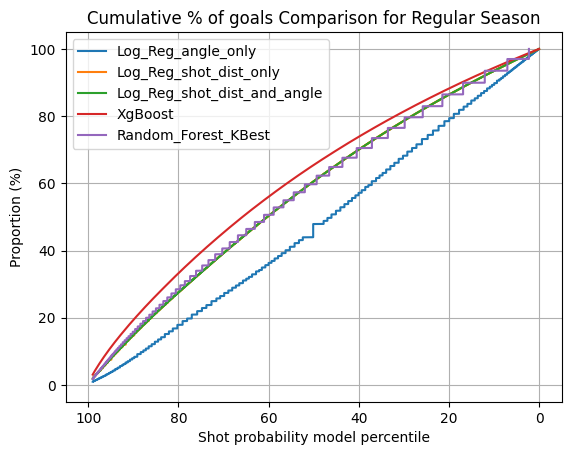

In [196]:
plt.plot(probas_and_label_1['rank'].iloc[start_length:],probas_and_label_1['cum_percent'].iloc[start_length:],label="Log_Reg_angle_only")
plt.plot(probas_and_label_2['rank'].iloc[start_length:],probas_and_label_2['cum_percent'].iloc[start_length:],label="Log_Reg_shot_dist_only")
plt.plot(probas_and_label_3['rank'].iloc[start_length:],probas_and_label_3['cum_percent'].iloc[start_length:],label="Log_Reg_shot_dist_and_angle")
plt.plot(probas_and_label_4['rank'].iloc[start_length:],probas_and_label_4['cum_percent'].iloc[start_length:],label="XgBoost")
plt.plot(probas_and_label_5['rank'].iloc[start_length:],probas_and_label_5['cum_percent'].iloc[start_length:],label="Random_Forest_KBest")

plt.title(f'Cumulative % of goals Comparison for Regular Season')
plt.xlim([105,-5])
plt.ylim([-5,105])
plt.grid(True)
plt.ylabel("Proportion (%)")
plt.xlabel("Shot probability model percentile")
plt.legend()

### Reliability 
ref: https://www.geeksforgeeks.org/probability-calibration-curve-in-scikit-learn/

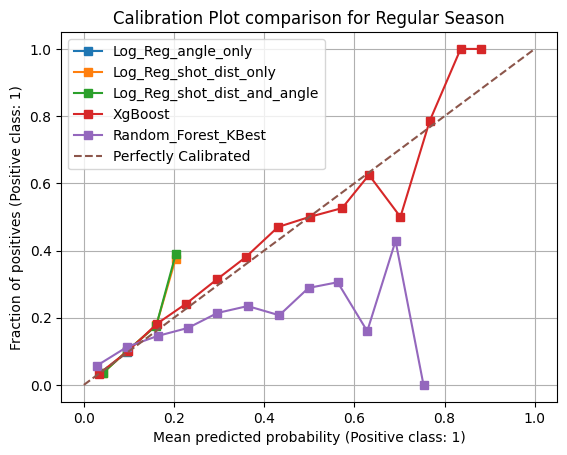

In [197]:
true_pos1, pred_pos1 = calibration_curve(test_regular_df_Y, log_reg_1.predict_proba(regular_reg_1_X)[:,1], n_bins=15)
true_pos2, pred_pos2 = calibration_curve(test_regular_df_Y, log_reg_2.predict_proba(regular_reg_2_X)[:,1], n_bins=15)
true_pos3, pred_pos3 = calibration_curve(test_regular_df_Y, log_reg_3.predict_proba(regular_reg_3_X)[:,1], n_bins=15)
true_pos4, pred_pos4 = calibration_curve(test_regular_df_Y, xgboost.predict_proba(regular_reg_4_X)[:,1], n_bins=15)
true_pos5, pred_pos5 = calibration_curve(test_regular_df_Y, rf.predict_proba(regular_reg_5_X)[:,1], n_bins=15)


plt.plot(pred_pos1,true_pos1, marker='s', label='Log_Reg_angle_only')
plt.plot(pred_pos2,true_pos2, marker='s',label='Log_Reg_shot_dist_only')
plt.plot(pred_pos3,true_pos3, marker='s', label='Log_Reg_shot_dist_and_angle')
plt.plot(pred_pos4,true_pos4 , marker='s',label='XgBoost')
plt.plot(pred_pos5,true_pos5,  marker='s',label='Random_Forest_KBest')
 
plt.title(f'Calibration Plot comparison for Regular Season')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')
plt.xlabel('Mean predicted probability (Positive class: 1)')
plt.ylabel('Fraction of positives (Positive class: 1)')
plt.grid(True)
plt.legend()

### Off-Season

In [198]:
df_off= df_off[['game_time','period','x','y','shot_type','last_event_type',
       'x_coord_last_event', 'y_coord_last_event', 'Time_from_the_last_event',
       'Distance_from_the_last_event', 'Rebound', 'change_shot_angle', 'Speed',
       'shot_dist','angle_net', 'is_goal']]

In [199]:
test_shot_type_oh_off = onehot_generator(df_off[['shot_type']])
test_last_event_type_oh_off = onehot_generator(df_off[['last_event_type']])
test_off_df= df_off.drop(columns=['shot_type','last_event_type'])
test_off_df = pd.concat([test_off_df,
                       test_shot_type_oh_off.set_index(test_off_df.index),
                       test_last_event_type_oh_off.set_index(test_off_df.index)],axis=1)

In [200]:
test_off_df = test_off_df.drop(columns=['change_shot_angle'])
test_off_df = test_off_df.dropna()

In [201]:
test_off_df_X = test_off_df.drop(columns=['is_goal'])
test_off_df_Y = test_off_df[['is_goal']]

In [202]:
off_reg_1_X = test_off_df[['angle_net']]
off_reg_2_X = test_off_df[['shot_dist']]
off_reg_3_X = test_off_df[['shot_dist','angle_net']]
off_reg_4_X = test_off_df[['game_time', 'period', 'y', 'Time_from_the_last_event', 'shot_dist', 'shot_type_Backhand', 'shot_type_Deflected', 'shot_type_Wrap-around', 'shot_type_Wrist Shot', 'last_event_type_Hit', 'last_event_type_Missed Shot', 'last_event_type_Shot', 'last_event_type_Stoppage']]
off_reg_5_X = test_off_df[['x','y','Time_from_the_last_event','Distance_from_the_last_event',
 'Rebound','Speed','shot_dist','angle_net','shot_type_Wrist Shot','last_event_type_Shot']]

In [203]:
val_res_1_off = log_reg_1.predict_proba(off_reg_1_X)
val_res_2_off = log_reg_2.predict_proba(off_reg_2_X)
val_res_3_off = log_reg_3.predict_proba(off_reg_3_X)
val_res_4_off = xgboost.predict_proba(off_reg_4_X)
val_res_5_off = rf.predict_proba(off_reg_5_X)

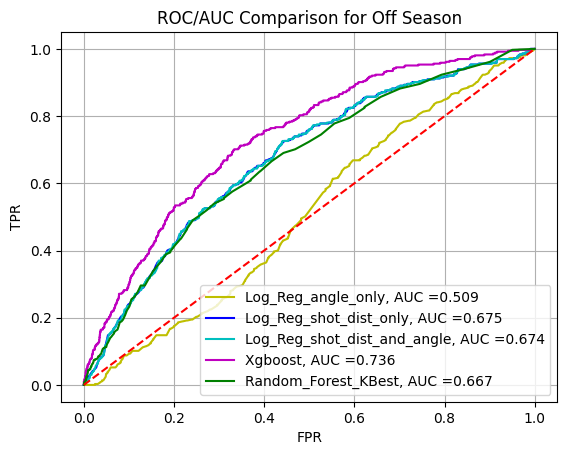

In [204]:
fpr_1,tpr_1,threshold_1 = metrics.roc_curve(test_off_df_Y,val_res_1_off[:,1])
fpr_2,tpr_2,threshold_2 = metrics.roc_curve(test_off_df_Y,val_res_2_off[:,1])
fpr_3,tpr_3,threshold_3 = metrics.roc_curve(test_off_df_Y,val_res_3_off[:,1])
fpr_4,tpr_4,threshold_4 = metrics.roc_curve(test_off_df_Y,val_res_4_off[:,1])
fpr_5,tpr_5,threshold_5 = metrics.roc_curve(test_off_df_Y,val_res_5_off[:,1])

auc_1 = metrics.auc(fpr_1,tpr_1)
auc_2 = metrics.auc(fpr_2,tpr_2)
auc_3 = metrics.auc(fpr_3,tpr_3)
auc_4 = metrics.auc(fpr_4,tpr_4)
auc_5 = metrics.auc(fpr_5,tpr_5)


plt.title(f'ROC/AUC Comparison for Off Season')
plt.plot(fpr_1,tpr_1,'y',label=f"Log_Reg_angle_only, AUC =%0.3f"%auc_1)
plt.plot(fpr_2,tpr_2,'b',label=f"Log_Reg_shot_dist_only, AUC =%0.3f"%auc_2)
plt.plot(fpr_3,tpr_3,'c',label=f"Log_Reg_shot_dist_and_angle, AUC =%0.3f"%auc_3)
plt.plot(fpr_4,tpr_4,'m',label=f"Xgboost, AUC =%0.3f"%auc_4)
plt.plot(fpr_5,tpr_5,'g',label=f"Random_Forest_KBest, AUC =%0.3f"%auc_5)

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.grid(True)
plt.legend(loc="lower right")

In [205]:
probas_and_label_1_off = helper_df(test_off_df_Y,val_res_1_off)
probas_and_label_2_off = helper_df(test_off_df_Y,val_res_2_off)
probas_and_label_3_off = helper_df(test_off_df_Y,val_res_3_off)
probas_and_label_4_off = helper_df(test_off_df_Y,val_res_4_off)
probas_and_label_5_off = helper_df(test_off_df_Y,val_res_5_off)

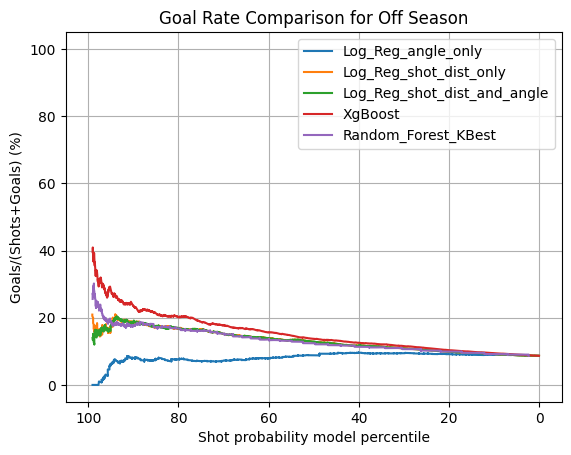

In [206]:
start_length = int(len(probas_and_label_1_off)*0.01)
plt.plot(probas_and_label_1_off['rank'].iloc[start_length:],probas_and_label_1_off['#goal/#goal+#shot'].iloc[start_length:],label="Log_Reg_angle_only")
plt.plot(probas_and_label_2_off['rank'].iloc[start_length:],probas_and_label_2_off['#goal/#goal+#shot'].iloc[start_length:],label="Log_Reg_shot_dist_only")
plt.plot(probas_and_label_3_off['rank'].iloc[start_length:],probas_and_label_3_off['#goal/#goal+#shot'].iloc[start_length:],label="Log_Reg_shot_dist_and_angle")
plt.plot(probas_and_label_4_off['rank'].iloc[start_length:],probas_and_label_4_off['#goal/#goal+#shot'].iloc[start_length:],label="XgBoost")
plt.plot(probas_and_label_5_off['rank'].iloc[start_length:],probas_and_label_5_off['#goal/#goal+#shot'].iloc[start_length:],label="Random_Forest_KBest")

plt.title(f'Goal Rate Comparison for Off Season')
plt.xlim([105,-5])
plt.ylim([-5,105])
plt.grid(True)
plt.ylabel("Goals/(Shots+Goals) (%)")
plt.xlabel("Shot probability model percentile")
plt.legend()

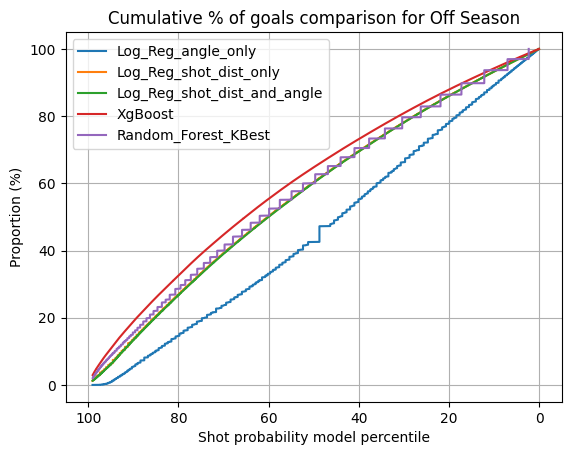

In [207]:
plt.plot(probas_and_label_1_off['rank'].iloc[start_length:],probas_and_label_1_off['cum_percent'].iloc[start_length:],label="Log_Reg_angle_only")
plt.plot(probas_and_label_2_off['rank'].iloc[start_length:],probas_and_label_2_off['cum_percent'].iloc[start_length:],label="Log_Reg_shot_dist_only")
plt.plot(probas_and_label_3_off['rank'].iloc[start_length:],probas_and_label_3_off['cum_percent'].iloc[start_length:],label="Log_Reg_shot_dist_and_angle")
plt.plot(probas_and_label_4_off['rank'].iloc[start_length:],probas_and_label_4_off['cum_percent'].iloc[start_length:],label="XgBoost")
plt.plot(probas_and_label_5_off['rank'].iloc[start_length:],probas_and_label_5_off['cum_percent'].iloc[start_length:],label="Random_Forest_KBest")

plt.title(f'Cumulative % of goals comparison for Off Season')
plt.xlim([105,-5])
plt.ylim([-5,105])
plt.grid(True)
plt.ylabel("Proportion (%)")
plt.xlabel("Shot probability model percentile")
plt.legend()

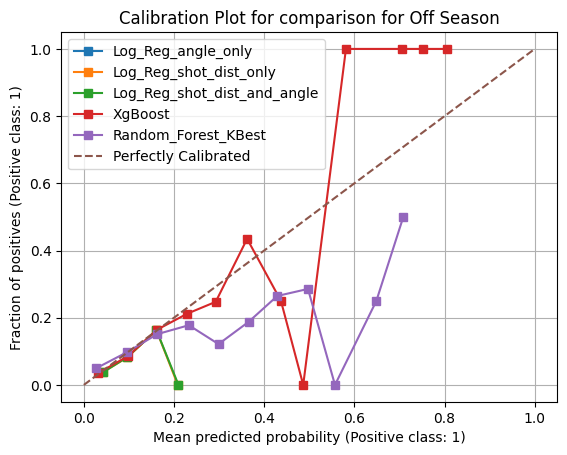

In [208]:
true_pos1, pred_pos1 = calibration_curve(test_off_df_Y, log_reg_1.predict_proba(off_reg_1_X)[:,1], n_bins=15)
true_pos2, pred_pos2 = calibration_curve(test_off_df_Y, log_reg_2.predict_proba(off_reg_2_X)[:,1], n_bins=15)
true_pos3, pred_pos3 = calibration_curve(test_off_df_Y, log_reg_3.predict_proba(off_reg_3_X)[:,1], n_bins=15)
true_pos4, pred_pos4 = calibration_curve(test_off_df_Y, xgboost.predict_proba(off_reg_4_X)[:,1], n_bins=15)
true_pos5, pred_pos5 = calibration_curve(test_off_df_Y, rf.predict_proba(off_reg_5_X)[:,1], n_bins=15)


plt.plot(pred_pos1,true_pos1, marker='s', label='Log_Reg_angle_only')
plt.plot(pred_pos2,true_pos2, marker='s',label='Log_Reg_shot_dist_only')
plt.plot(pred_pos3,true_pos3, marker='s', label='Log_Reg_shot_dist_and_angle')
plt.plot(pred_pos4,true_pos4 , marker='s',label='XgBoost')
plt.plot(pred_pos5,true_pos5,  marker='s',label='Random_Forest_KBest')
 
plt.title(f'Calibration Plot for comparison for Off Season')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')
plt.xlabel('Mean predicted probability (Positive class: 1)')
plt.ylabel('Fraction of positives (Positive class: 1)')
plt.grid(True)
plt.legend()